In [5]:
# NV Energy Analysis Notebook

import utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Load and process data
data_directory = 'data'
demand_data, usage_data = utils.load_and_process_data(data_directory)

# Resample data to hourly intervals
demand_hourly, usage_hourly = utils.resample_hourly(demand_data, usage_data)

# Get user rate information
rates = utils.get_user_rates()

# Add rate and cost information to usage data
usage_hourly = utils.add_rate_and_cost(usage_hourly, rates)

Please enter your electricity rates and time-of-use periods.
Press Enter without any input to use all default values.
Or enter custom values, pressing Enter after each to use the default for that item.


Press Enter to use all defaults, or type anything to enter custom values:  


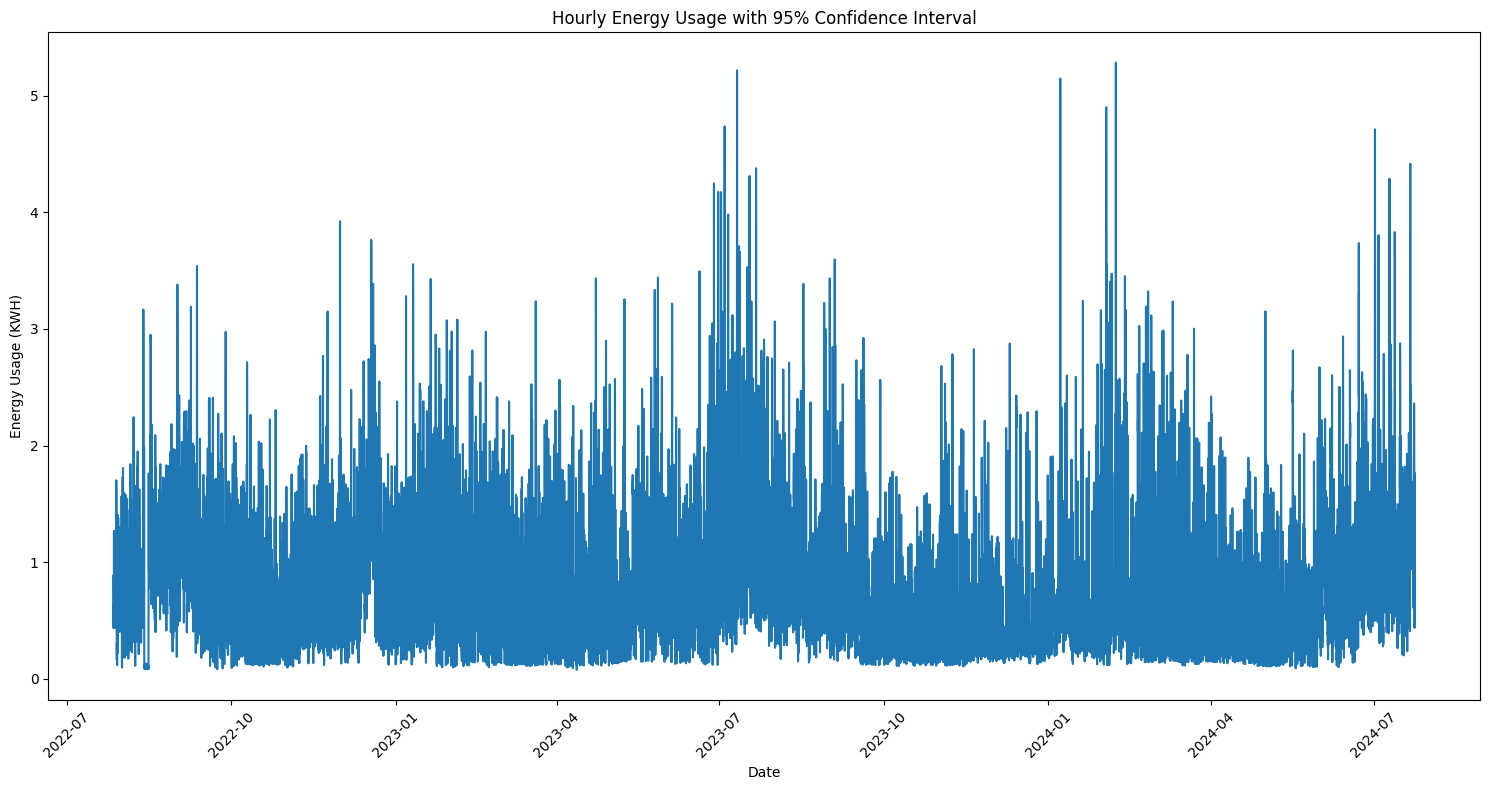

In [6]:
# 1. Time Series Plot with Confidence Bands
plt.figure(figsize=(15, 8))
sns.lineplot(x=usage_hourly.index, y=usage_hourly['usage'], errorbar=('ci', 95))
plt.title('Hourly Energy Usage with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Energy Usage (KWH)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

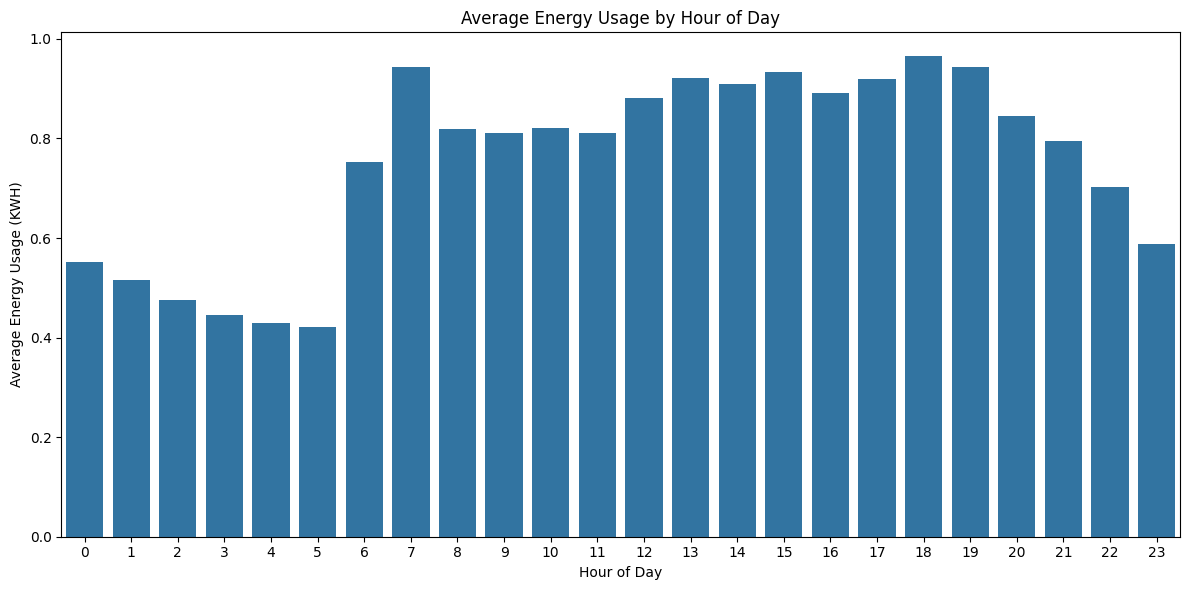

In [7]:
# 2. Histogram of Energy Usage by Hour of Day
usage_hourly.index = usage_hourly.index.tz_localize(None)
hourly_usage = usage_hourly['usage'].groupby(usage_hourly.index.hour).mean()
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_usage.index, y=hourly_usage.values)
plt.title('Average Energy Usage by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Usage (KWH)')
plt.tight_layout()
plt.show()

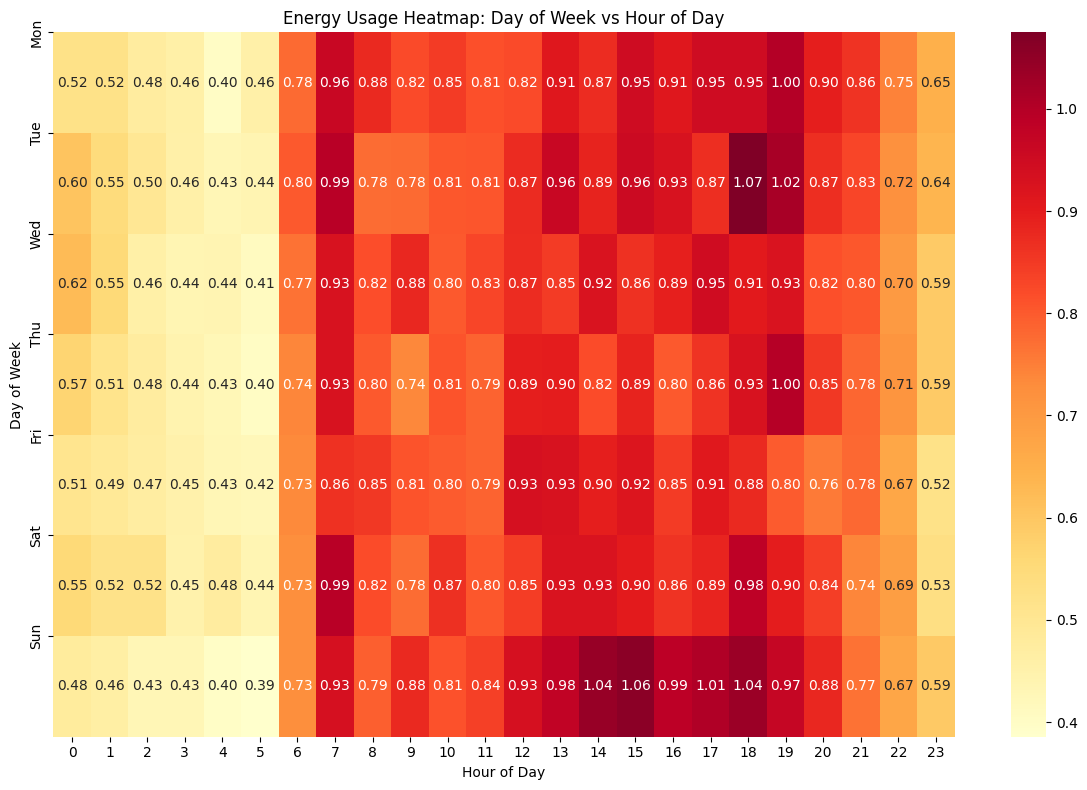

In [8]:
# 3. Heatmap of Energy Usage by Day of Week and Hour
usage_pivot = usage_hourly['usage'].groupby([usage_hourly.index.dayofweek, usage_hourly.index.hour]).mean().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(usage_pivot, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Energy Usage Heatmap: Day of Week vs Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.show()

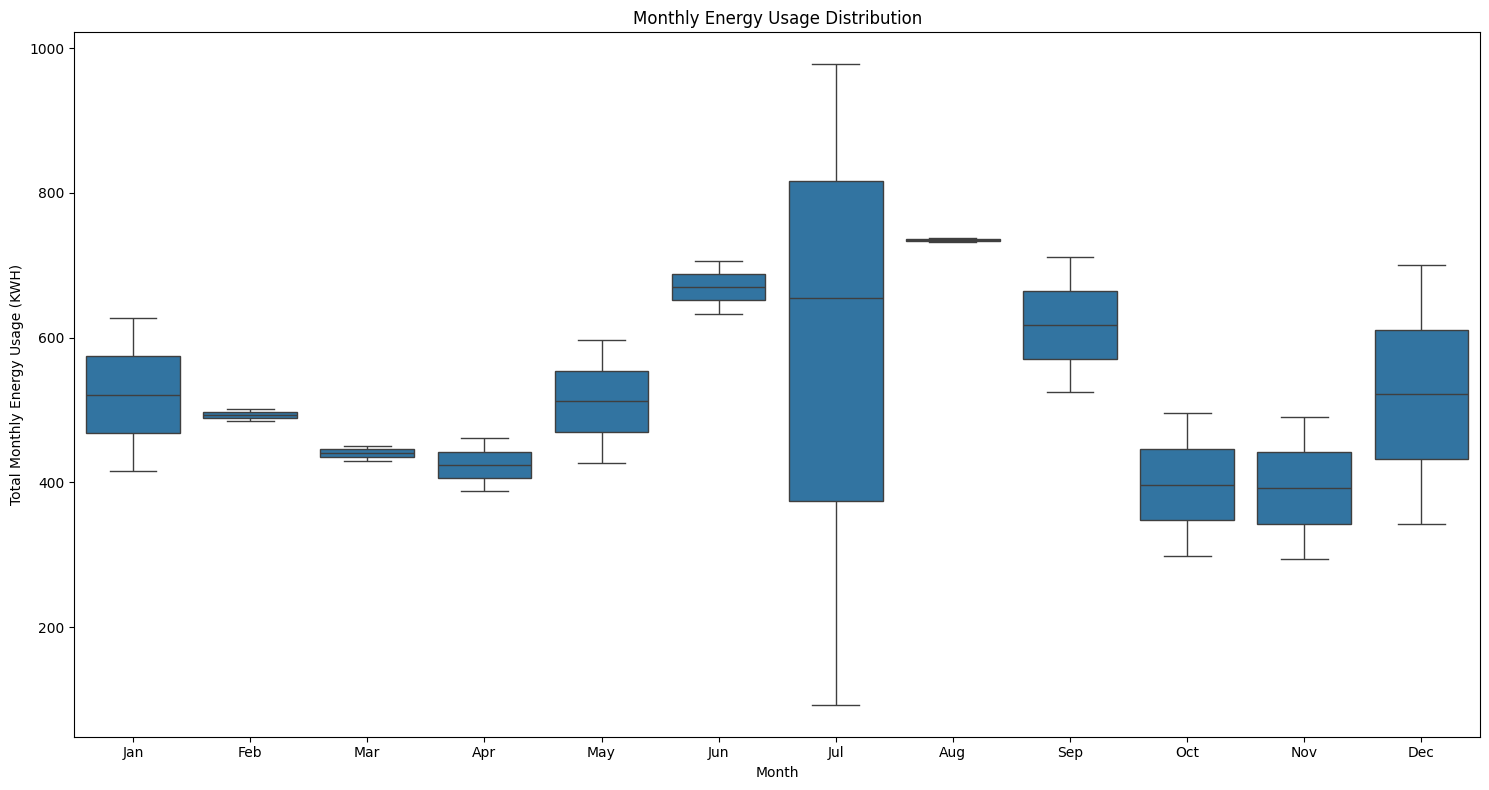

In [9]:
# 4. Monthly Energy Usage Box Plot
monthly_usage = usage_hourly['usage'].resample('ME').sum()
plt.figure(figsize=(15, 8))
sns.boxplot(x=monthly_usage.index.month, y=monthly_usage.values)
plt.title('Monthly Energy Usage Distribution')
plt.xlabel('Month')
plt.ylabel('Total Monthly Energy Usage (KWH)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

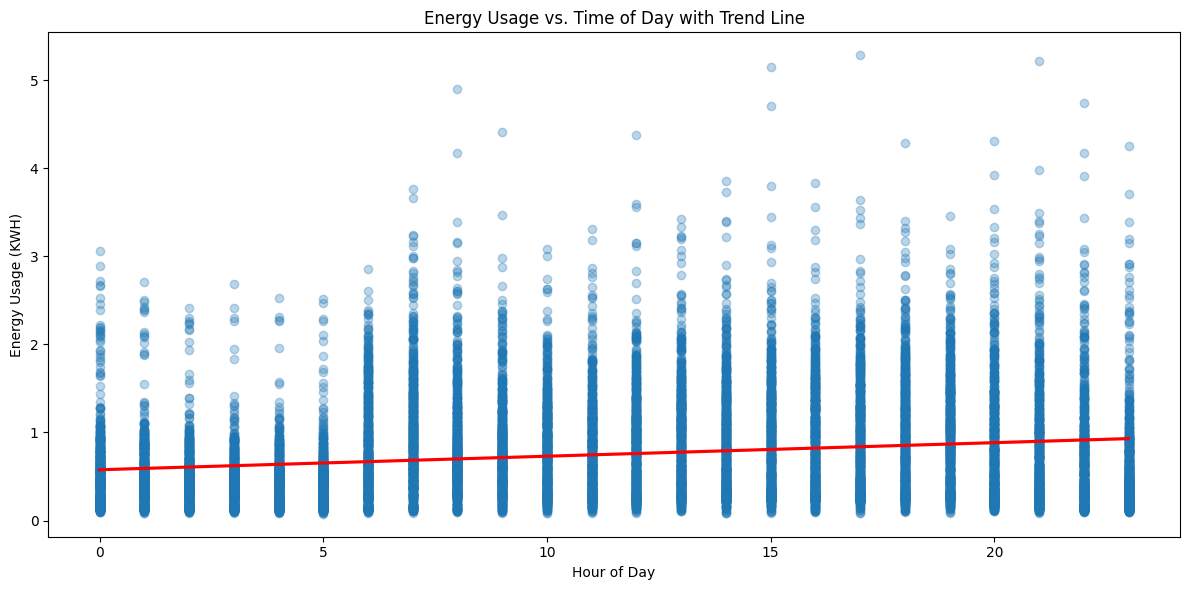

In [10]:
# 5. Energy Usage vs. Time of Day Scatter Plot with Trend Line
hourly_data = pd.DataFrame({'hour': usage_hourly.index.hour, 'usage': usage_hourly['usage'].values})
plt.figure(figsize=(12, 6))
sns.regplot(x='hour', y='usage', data=hourly_data, scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
plt.title('Energy Usage vs. Time of Day with Trend Line')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Usage (KWH)')
plt.tight_layout()
plt.show()

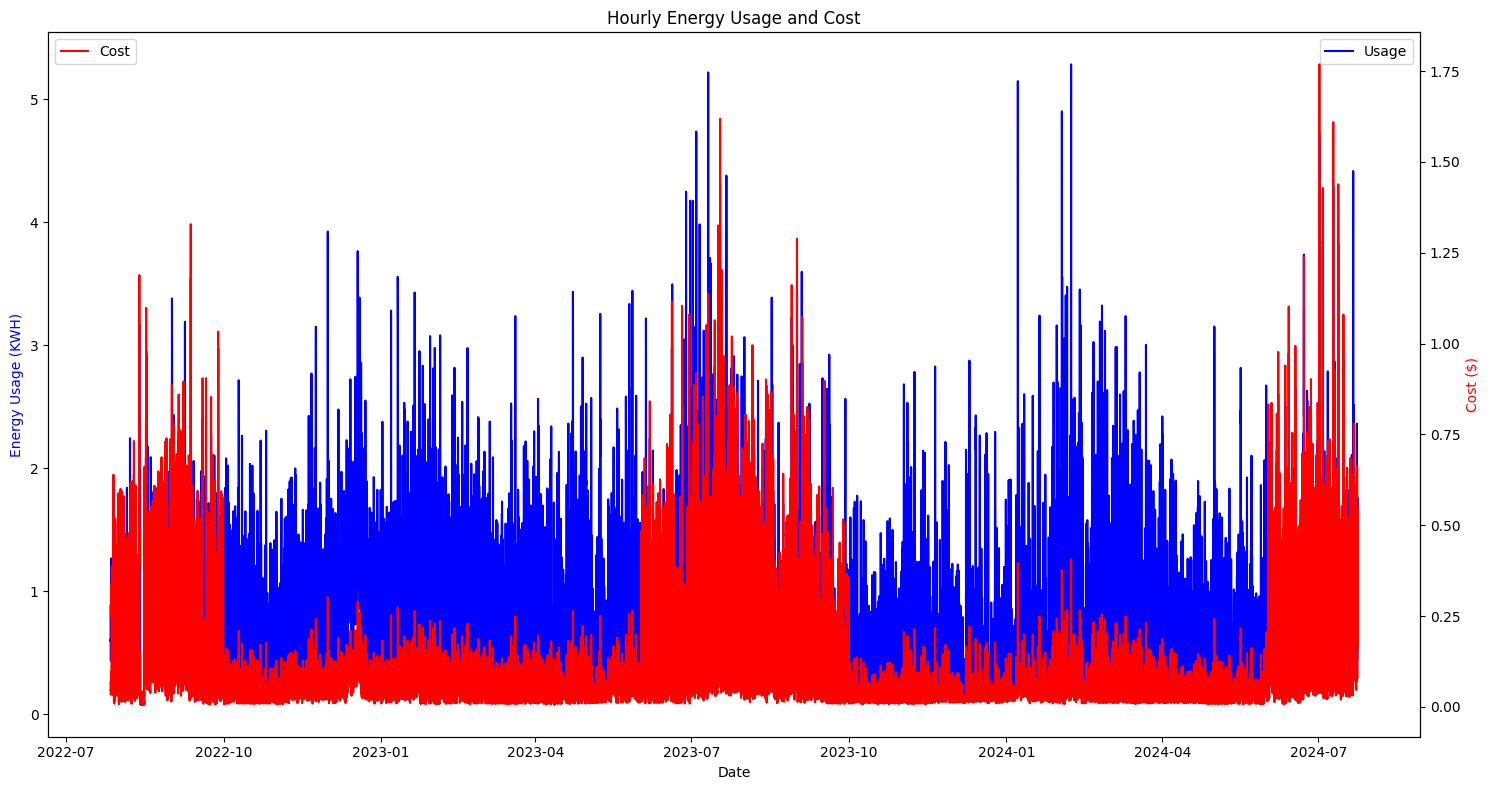

In [11]:
# 6. Time Series Plot with Cost Overlay
plt.figure(figsize=(15, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()

sns.lineplot(x=usage_hourly.index, y=usage_hourly['usage'], ax=ax1, color='blue', label='Usage')
sns.lineplot(x=usage_hourly.index, y=usage_hourly['cost'], ax=ax2, color='red', label='Cost')

ax1.set_xlabel('Date')
ax1.set_ylabel('Energy Usage (KWH)', color='blue')
ax2.set_ylabel('Cost ($)', color='red')

plt.title('Hourly Energy Usage and Cost')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

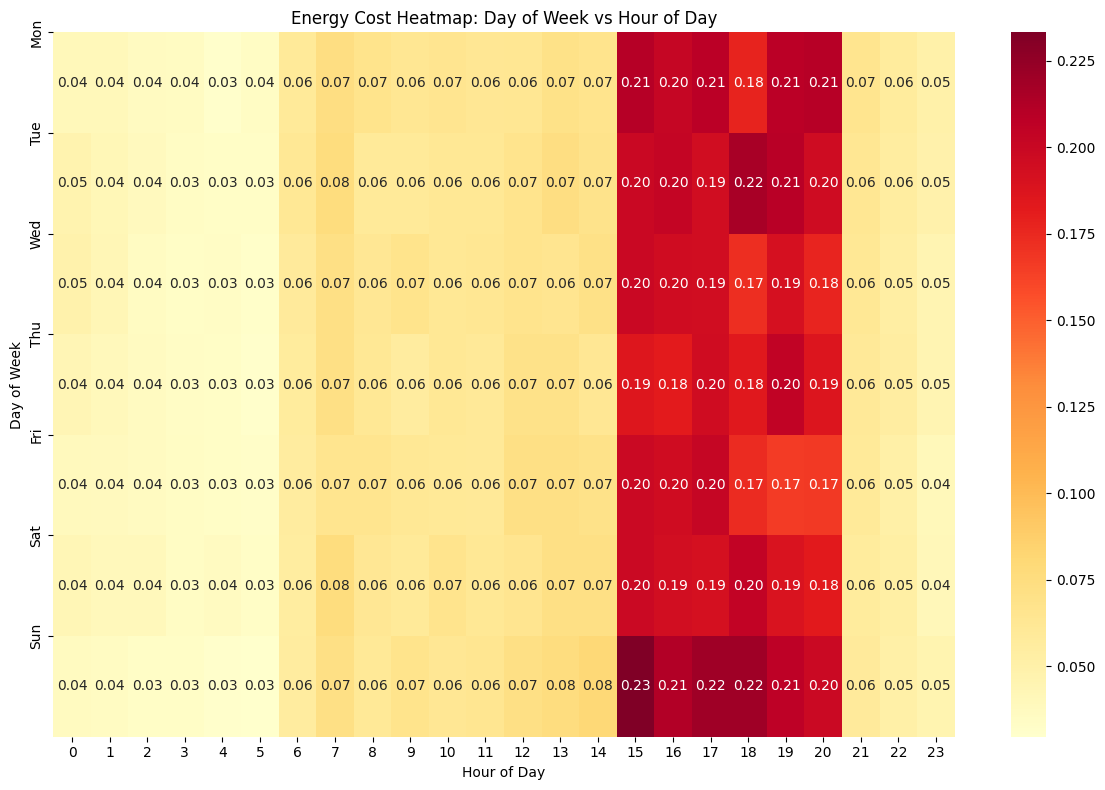

In [12]:
# 7. Heatmap of Energy Cost by Day of Week and Hour
cost_pivot = usage_hourly['cost'].groupby([usage_hourly.index.dayofweek, usage_hourly.index.hour]).mean().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(cost_pivot, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Energy Cost Heatmap: Day of Week vs Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.show()

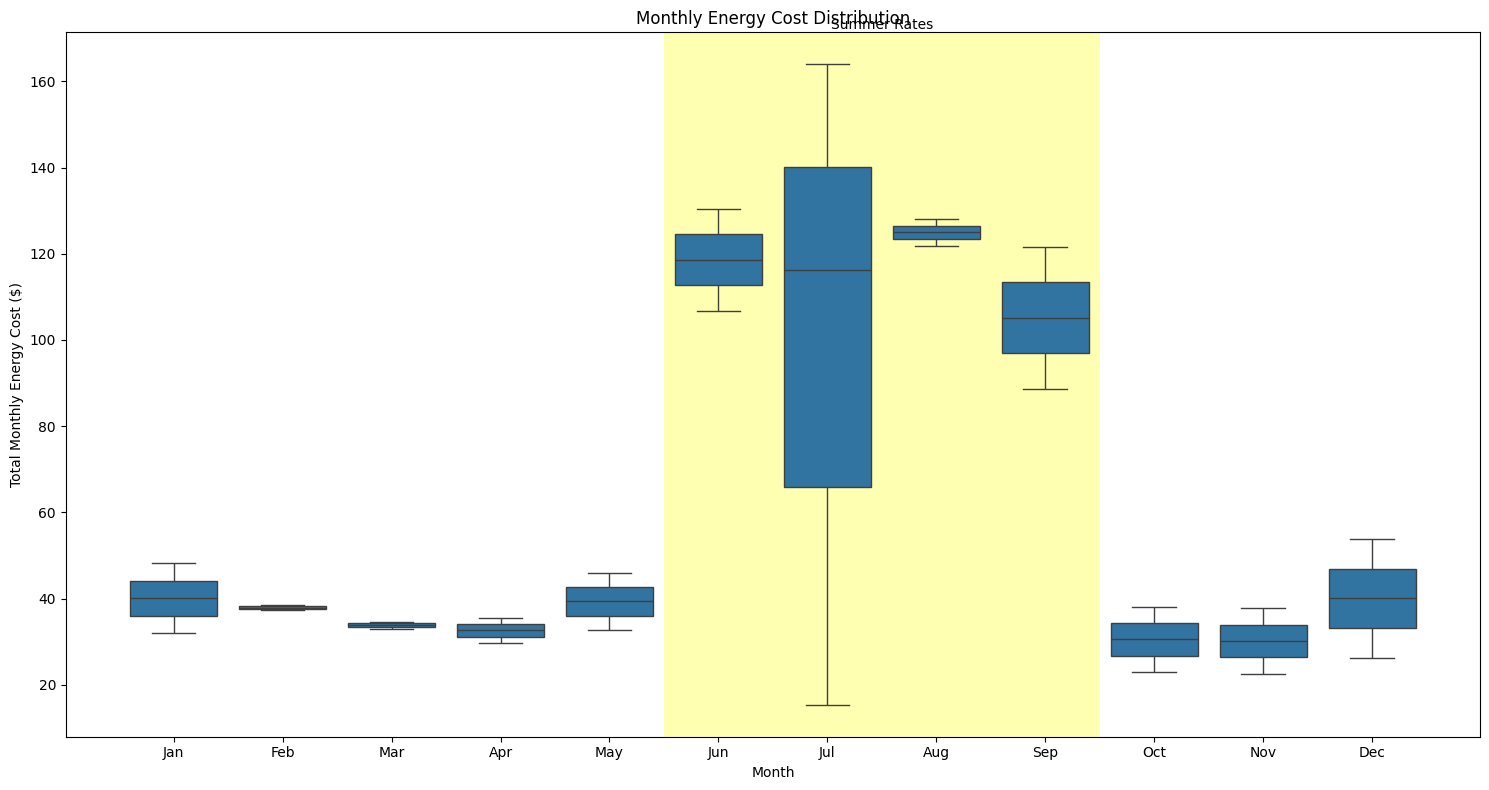

In [13]:
# 8. Monthly Energy Cost Box Plot with Season Highlight
monthly_cost = usage_hourly['cost'].resample('ME').sum()
plt.figure(figsize=(15, 8))
sns.boxplot(x=monthly_cost.index.month, y=monthly_cost.values)
plt.title('Monthly Energy Cost Distribution')
plt.xlabel('Month')
plt.ylabel('Total Monthly Energy Cost ($)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Highlight summer months
summer_range = range(rates['summer_start']-1, rates['summer_end'])
for month in summer_range:
    plt.axvspan(month-0.5, month+0.5, facecolor='yellow', alpha=0.3)
plt.text(np.mean(summer_range), plt.ylim()[1], 'Summer Rates', ha='center', va='bottom')

plt.tight_layout()
plt.show()

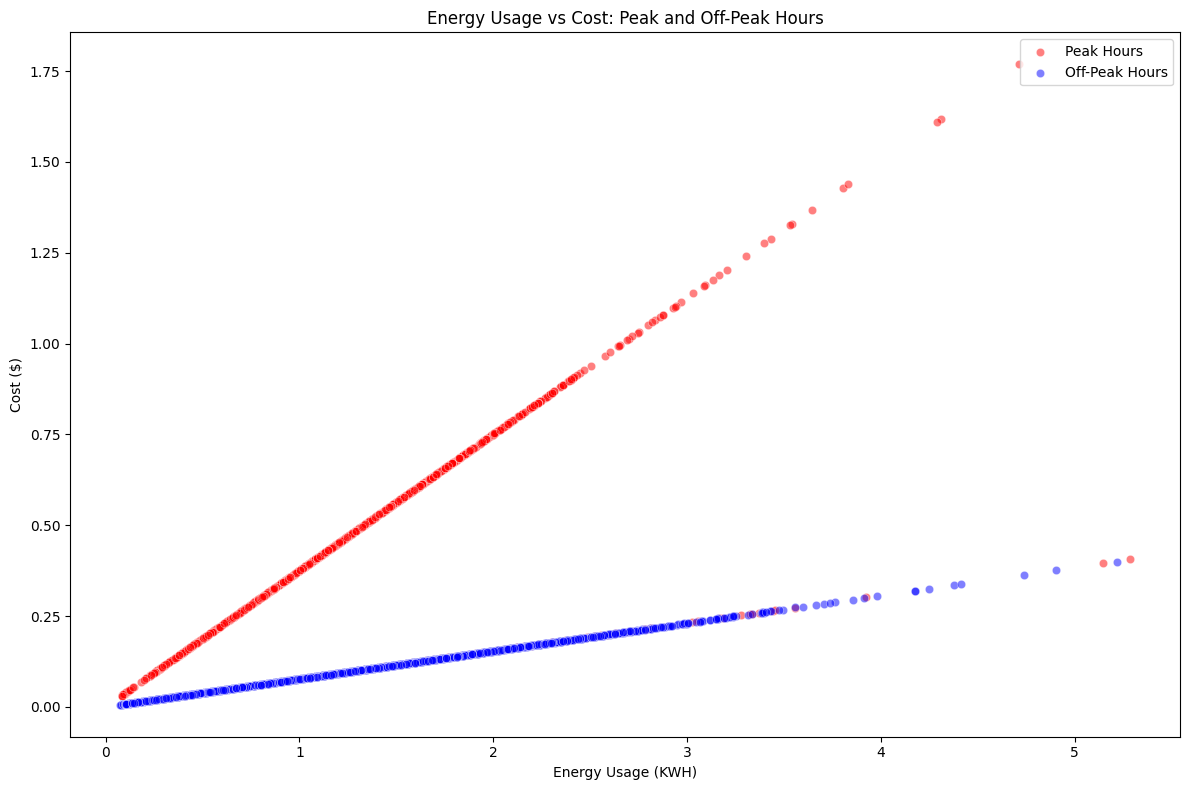

In [14]:
# 9. Usage vs Cost Scatter Plot with Peak/Off-Peak Highlight
plt.figure(figsize=(12, 8))
peak_mask = (usage_hourly.index.hour >= rates['peak_start']) & (usage_hourly.index.hour < rates['peak_end'])
sns.scatterplot(x='usage', y='cost', data=usage_hourly[peak_mask], label='Peak Hours', color='red', alpha=0.5)
sns.scatterplot(x='usage', y='cost', data=usage_hourly[~peak_mask], label='Off-Peak Hours', color='blue', alpha=0.5)
plt.title('Energy Usage vs Cost: Peak and Off-Peak Hours')
plt.xlabel('Energy Usage (KWH)')
plt.ylabel('Cost ($)')
plt.legend()
plt.tight_layout()
plt.show()

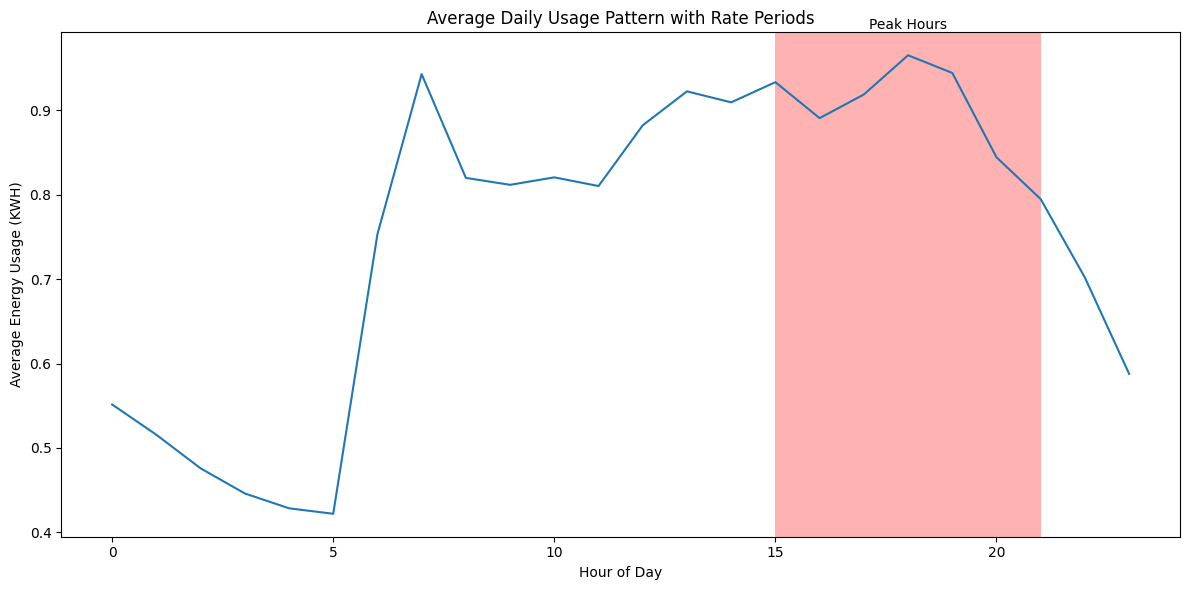

In [15]:
# 10. Daily Usage Pattern with Rate Periods
daily_usage = usage_hourly['usage'].groupby(usage_hourly.index.hour).mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_usage.index, y=daily_usage.values)
plt.title('Average Daily Usage Pattern with Rate Periods')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Usage (KWH)')

# Highlight peak hours
plt.axvspan(rates['peak_start'], rates['peak_end'], facecolor='red', alpha=0.3)
plt.text(np.mean([rates['peak_start'], rates['peak_end']]), plt.ylim()[1], 'Peak Hours', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [16]:
# Calculate and display statistics
total_cost = usage_hourly['cost'].sum()
avg_daily_cost = usage_hourly['cost'].resample('D').sum().mean()
peak_mask = (usage_hourly.index.hour >= rates['peak_start']) & (usage_hourly.index.hour < rates['peak_end'])
peak_usage_cost = usage_hourly[peak_mask]['cost'].sum()
off_peak_usage_cost = usage_hourly[~peak_mask]['cost'].sum()

print(f"Total Cost: ${total_cost:.2f}")
print(f"Average Daily Cost: ${avg_daily_cost:.2f}")
print(f"Peak Hours Cost: ${peak_usage_cost:.2f} ({peak_usage_cost/total_cost*100:.1f}% of total)")
print(f"Off-Peak Hours Cost: ${off_peak_usage_cost:.2f} ({off_peak_usage_cost/total_cost*100:.1f}% of total)")

Total Cost: $1562.25
Average Daily Cost: $2.15
Peak Hours Cost: $858.93 (55.0% of total)
Off-Peak Hours Cost: $703.31 (45.0% of total)


In [17]:
# Get and display peak usage times
peak_times = utils.get_peak_times(usage_hourly['usage'])
print("\nPeak Usage Times:")
print(peak_times)

print("Analysis complete.")


Peak Usage Times:
startTime
2024-02-07 17:00:00    5.28375
2023-07-10 21:00:00    5.21825
2024-01-07 15:00:00    5.14750
2024-02-02 08:00:00    4.90200
2023-07-03 22:00:00    4.73675
Name: usage, dtype: float64
Analysis complete.
